# **REDES LSTM para predicción de la demanda eléctrica en Mallorca**

> Name: **Samuel Lozano Gómez** 

Para la realización del mismo me he inspirado en el trabajo realizado por Miguel Sotaquirá en [1]

[1] __[Link](https://www.codificandobits.com/blog/series-de-tiempo-redes-lstm-prediccion-univariada-unistep/#introducci%C3%B3n)__

### Tabla de contenidos <a id="0"></a>

***

- 1.[Introducción](#1)
    - 1.1 [Librerías](#1.1)
    - 1.2 [Datos](#1.2)

<br>

- 2.[Conjuntos de Train, Validación y Test](#2)
    - 2.1 [Creación de los Datasets](#2.1)

<br>

- 3.[Escalado de datos](#3)

<br>

- 4.[MODELOS](#4)
    - 4.1 [Creación Red LSTM tentativa](#4.1)
        - 4.1.1 [Definición del modelo](#4.1.1)
        - 4.1.2 [Ajuste del modelo](#4.1.2)
        - 4.1.3 [Evaluación del modelo](#4.1.3)
        - 4.1.4 [Predicciones](#4.1.4)
        - 4.1.5 [Conclusiones del modelo](#4.1.5)
    - 4.2 [Modelo 2](#4.2)
        - 4.2.1 [Definición del modelo](#4.2.1)
        - 4.2.2 [Conclusiones del modelo](#4.2.2)
    - 4.3 [Modelo 3](#4.3)
        - 4.3.1 [Definición del modelo](#4.3.1)
        - 4.3.2 [Conclusiones del modelo](#4.3.2)
    - 4.4 [Modelo con Variable Exógena](#4.4)
        - 4.4.1 [Definición del modelo](#4.4.1)
        - 4.4.2 [Conclusiones del modelo](#4.4.2)

<br>

- 5.[Modelo escogido](#5)

***

## 1.[Introducción](#0) <a id="1"></a>

En este notebook mostramos los pasos realizados para la predicción de la demanda eléctrica en Mallorca utilizando los dos últimos meses, con registros horarios. Y compararemos estos resultados con los consiguientes utilizando la temperatura de Mallorca, obtenida en la misma escala de agregacición, como variable exógena. Esta relación ya ha sido demostrada en el script de R.

<br>

Para ello utilizaremos Redes Neuronales Recurrentes, las Redes LSTM.

### 1.1 [Importamos Librerías](#0) <a id="1.1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openpyxl

### 1.2 [Cargamos los datos](#0) <a id="1.2"></a>

In [23]:
df = pd.read_excel("Mallorca.xlsx")
print(df.head())
print("Las dimensiones son:", df.shape)
print(f"Esto hace un total de {int(df.shape[0]/24//30)} meses == {int(df.shape[0]/24)} días, aprox= {int(df.shape[0]/24/7)} semanas")        

   tempm  demanda
0     18    365.8
1     18    333.5
2     17    315.5
3     18    307.8
4     18    304.8
Las dimensiones son: (1464, 2)
Esto hace un total de 2 meses == 61 días, aprox= 8 semanas


## 2. [Creamos Conjuntos Train, Validation y Test](#0) <a id="2"></a>

A fin de comparar los resultados con las redes propuestas en R, trataremos de predecir las últimas 168 horas, esto es la última semana, utilizando el RMSE. Para el dataset de validación escogeremos la penúltima semana (168 horas) y para el dataset de test la última semana (168 horas).

In [3]:
n = 168 #168 horas equivalen a 7 días, y esto a 1 semana
train = df["demanda"][0:-n*2]
val = df["demanda"][-n*2:-n]
test = df["demanda"][-n::]

print("El tamaño de entrenamiento es", train.shape)
print("El tamaño de validación es", val.shape)
print("El tamaño de test es", test.shape)

El tamaño de entrenamiento es (1128,)
El tamaño de validación es (168,)
El tamaño de test es (168,)


## 2.1 [Creación de los Datasets](#0) <a id="2.1"></a>

Creamos los conjuntos de datos que recibirán los modelos, inputs y outputs de entrenamiento, validación y test. En este primer enfoque consideraremos los 24 instantes anteriores para predecir el siguiente. Esto porque ya sabemos del análisis descriptivo que hay estacionalidad de 24 horas.

In [4]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

input_length = 24
output_length = 1

#Seleccionamos 1 semana de validación, 1 semana de test, y el resto para train
ntrain = len(df)-2*24*7-input_length
nval = 24*7

array = df["demanda"].values
shape = array.shape
if len(shape)==1: # Si tenemos sólo una serie (univariado)
    fils, cols = array.shape[0], 1
    array = array.reshape(fils,cols)
else: # Multivariado
    fils, cols = array.shape

for i in range(fils-input_length-output_length):
    if len(x_train) < ntrain:
        x_train.append(array[i:i+input_length,0:cols])
        y_train.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    elif len(x_val) < nval:
        x_val.append(array[i:i+input_length,0:cols])
        y_val.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    else:
        x_test.append(array[i:i+input_length,0:cols])
        y_test.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [5]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_train.shape}, y_tr: {y_train.shape}')
print(f'Set de validación - x_vl: {x_val.shape}, y_vl: {y_val.shape}')
print(f'Set de prueba - x_ts: {x_test.shape}, y_ts: {y_test.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (1104, 24, 1), y_tr: (1104, 1, 1)
Set de validación - x_vl: (168, 24, 1), y_vl: (168, 1, 1)
Set de prueba - x_ts: (167, 24, 1), y_ts: (167, 1, 1)


Esta es la serie frente al tiempo coloreada según los datasets

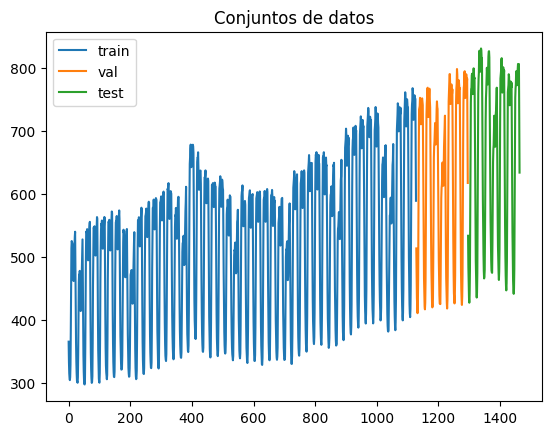

In [6]:
c = ["train", "val", "test"]
plt.figure()
for i,s in enumerate([train,val,test]):
    plt.plot(s, label = c[i])
plt.legend(loc="best")
plt.title("Conjuntos de datos")
plt.show()

# 3. [Escalamos los datos](#0) <a id="3"></a>

Utilizaremos el Min-Max scaler para el escalado

In [7]:
from sklearn.preprocessing import MinMaxScaler

NFEATS = x_train.shape[2]
scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

x_train_s = np.zeros(x_train.shape)
x_val_s = np.zeros(x_val.shape)
x_test_s = np.zeros(x_test.shape)
y_train_s = np.zeros(y_train.shape)
y_val_s = np.zeros(y_val.shape)
y_test_s = np.zeros(y_test.shape)

In [8]:
for i in range(NFEATS):
    x_train_s[:,:,i] = scalers[i].fit_transform(x_train[:,:,i])
    x_val_s[:,:,i] = scalers[i].transform(x_val[:,:,i])
    x_test_s[:,:,i] = scalers[i].transform(x_test[:,:,i])
y_train_s[:,:,0] = scalers[-1].fit_transform(y_train[:,:,0])
y_val_s[:,:,0] = scalers[-1].transform(y_val[:,:,0])
y_test_s[:,:,0] = scalers[-1].transform(y_test[:,:,0])

# 4. [MODELOS](#0) <a id="4"></a>

## 4.1 [Creación de Red LSTM tentativa](#0) <a id="4.1"></a>

En primer lugar veamos la capacidad un modelo LSTM sencillo con hiperparámetros normales. De este modo al ajustar los hiperparámetros veremos las diferencias 

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(33)

### 4.1.1 [Definición del modelo](#0) <a id="4.1.1"></a>

Utilizaremos el RMSE como función de pérdida al igual que en el resto de modelos NN del script R. Por el momento empezamos con una capa de 48 neuronas LSTM.

In [10]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

N_UNITS = 48
INPUT_SHAPE = (x_train_s.shape[1], x_train_s.shape[2])
OUTPUT_LENGTH = 1

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))
optimizador = Adam(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

### 4.1.2 [Ajuste del modelo](#0) <a id="4.1.2"></a>

Ajustamos el modelo con 25 épocas con Batch_Size igual a 1

In [11]:
EPOCHS = 25
BATCH_SIZE = 1

print(modelo.summary())
modelo.fit(
    x = x_train_s,
    y = y_train_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val_s, y_val_s),
    verbose=2
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48)                9600      
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 9649 (37.69 KB)
Trainable params: 9649 (37.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
1104/1104 - 10s - loss: 0.3916 - val_loss: 0.5274 - 10s/epoch - 9ms/step
Epoch 2/25
1104/1104 - 7s - loss: 0.3097 - val_loss: 0.4082 - 7s/epoch - 6ms/step
Epoch 3/25
1104/1104 - 7s - loss: 0.1997 - val_loss: 0.1631 - 7s/epoch - 6ms/step
Epoch 4/25
1104/1104 - 7s - loss: 0.1396 - val_loss: 0.1233 - 7s/epoch - 6ms/step
Epoch 5/25
1104/1104 - 7s - loss: 0.1306 - val_loss: 0.1211 - 7s/epoch - 6ms/step
E

### 4.1.3 [Evaluación del modelo](#0) <a id="4.1.3"></a>

La evaluación del modelo parece buena, no consideraríamos overfiting, a pesar de que los resultados de test sean algo peores a la validación.

In [12]:
rmse_train = modelo.evaluate(x=x_train_s, y=y_train_s, verbose=0)
rmse_val = modelo.evaluate(x=x_val_s, y=y_val_s, verbose=0)
rmse_test = modelo.evaluate(x=x_test_s, y=y_test_s, verbose=0)

print('Comparación de desempeños:')
print(f'  RMSE train:\t {rmse_train:.3f}')
print(f'  RMSE val:\t {rmse_val:.3f}')
print(f'  RMSE test:\t {rmse_test:.3f}')

Comparación de desempeños:
  RMSE train:	 0.089
  RMSE val:	 0.126
  RMSE test:	 0.157


### 4.1.4 [Predicciones](#0) <a id="4.1.4"></a>

De todos modos, lo visto anteriormente era con datos escalados, hemos de deshacer el escalado para entender verdaderamente el rendimiento de la predicción

In [13]:
def predecir(x, model, scaler):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

y_test_pred = predecir(x_test_s, modelo, scalers[0])
print(root_mean_squared_error(y_test.flatten(), y_test_pred))

tf.Tensor(37.27196769396487, shape=(), dtype=float64)


El RMSE resultado es de 37.27, lo cual no está nada mal para ser el tentativo, sabiendo el gran margen de mejora existente

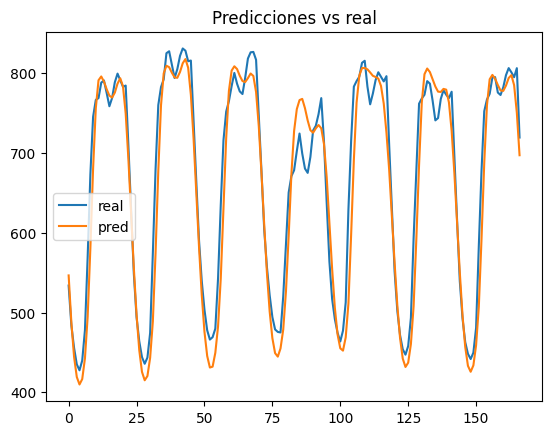

In [14]:
plt.figure()
plt.plot(range(len(y_test)), y_test.flatten(), label = "real")
plt.plot(range(len(y_test)), y_test_pred, label = "pred")
plt.legend(loc="best")
plt.title("Predicciones vs real")
plt.show()

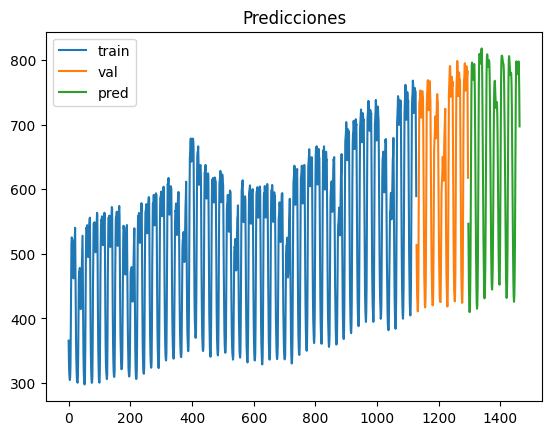

In [15]:
c = ["train", "val", "pred"]
plt.figure()
plt.plot(train, label = c[0])
plt.plot(val, label = c[1])
plt.plot(range(val.index.stop, val.index.stop+len(y_test_pred)), y_test_pred, label = c[2])
plt.legend(loc="best")
plt.title("Predicciones")
plt.show()

Las predicciones, además, no son malas, pero vemos varios desajustes en los máximos y mínimos

## 4.1.5 [Conclusiones del modelo](#0) <a id="4.1.5"></a>

<br>
    
El modelo no predice mal para ser el tentativo. Hemos considerado los 24 instantes anteriores para predecir el siguiente pues disponemos de estacionalidad diaria. También disponemos de semanal, esto sería cada 168 horas, por lo que este hiperparámetro deberemos afinarlo. Quizás sería interesante acomodar un modelo con las mismas condiciones que el ARIMA(1,1,1)x(1,1,1) que veíamos en R, considerando, el instante anterior, y los anteriores estacionalmente. También el tamaño de la capa LSTM, el cual hemos fijado a 48 puede variar.

## 4.2 [Modelo 2](#0) <a id="4.2"></a>

Variante utilizando para predecir el valor anterior, t-1, y los t-24 y t-168

In [16]:
# PARÁMETROS
input_length = 168
N_UNITS = 48
EPOCHS = 25
BATCH_SIZE = 1

### 4.2.1 [Definición del modelo](#0) <a id="4.2.1"></a>

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (960, 3, 1), y_tr: (960, 1, 1)
Set de validación - x_vl: (168, 3, 1), y_vl: (168, 1, 1)
Set de prueba - x_ts: (167, 3, 1), y_ts: (167, 1, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 48)                9600      
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 9649 (37.69 KB)
Trainable params: 9649 (37.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/25
960/960 - 6s - loss: 0.3829 - val_loss: 0.4250 - 6s/epoch - 6ms/step
Epoch 2/25
960/960 - 3s - loss: 0.2601 - val_loss: 0.2416 - 

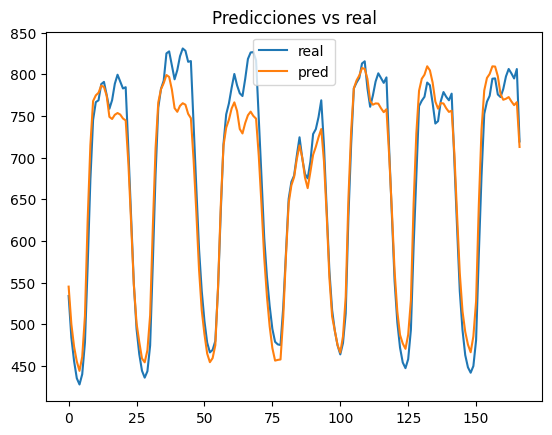

In [17]:
# CREACIÓN DATASETS

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

input_length = 168
output_length = 1

#Seleccionamos 1 semana de validación, 1 semana de test, y el resto para train
ntrain = len(df)-2*24*7-input_length
nval = 24*7

array = df["demanda"].values
shape = array.shape
if len(shape)==1: # Si tenemos sólo una serie (univariado)
    fils, cols = array.shape[0], 1
    array = array.reshape(fils,cols)
else: # Multivariado
    fils, cols = array.shape

for i in range(fils-input_length-output_length):
    if len(x_train) < ntrain:
        x_train.append(array[[i,i+7,i+input_length],0:cols])
        y_train.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    elif len(x_val) < nval:
        x_val.append(array[[i,i+7,i+input_length],0:cols])
        y_val.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    else:
        x_test.append(array[[i,i+7,i+input_length],0:cols])
        y_test.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_train.shape}, y_tr: {y_train.shape}')
print(f'Set de validación - x_vl: {x_val.shape}, y_vl: {y_val.shape}')
print(f'Set de prueba - x_ts: {x_test.shape}, y_ts: {y_test.shape}')

#ESCALADO

NFEATS = x_train.shape[2]
scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

x_train_s = np.zeros(x_train.shape)
x_val_s = np.zeros(x_val.shape)
x_test_s = np.zeros(x_test.shape)
y_train_s = np.zeros(y_train.shape)
y_val_s = np.zeros(y_val.shape)
y_test_s = np.zeros(y_test.shape)

for i in range(NFEATS):
    x_train_s[:,:,i] = scalers[i].fit_transform(x_train[:,:,i])
    x_val_s[:,:,i] = scalers[i].transform(x_val[:,:,i])
    x_test_s[:,:,i] = scalers[i].transform(x_test[:,:,i])
y_train_s[:,:,0] = scalers[-1].fit_transform(y_train[:,:,0])
y_val_s[:,:,0] = scalers[-1].transform(y_val[:,:,0])
y_test_s[:,:,0] = scalers[-1].transform(y_test[:,:,0])

# CREACIÓN RED NEURONAL

def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

INPUT_SHAPE = (x_train_s.shape[1], x_train_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))
optimizador = Adam(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)
print(modelo.summary())
historia = modelo.fit(
    x = x_train_s,
    y = y_train_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val_s, y_val_s),
    verbose=2
)

rmse_train = modelo.evaluate(x=x_train_s, y=y_train_s, verbose=0)
rmse_val = modelo.evaluate(x=x_val_s, y=y_val_s, verbose=0)
rmse_test = modelo.evaluate(x=x_test_s, y=y_test_s, verbose=0)

print('Comparación de desempeños:')
print(f'  RMSE train:\t {rmse_train:.3f}')
print(f'  RMSE val:\t {rmse_val:.3f}')
print(f'  RMSE test:\t {rmse_test:.3f}')

y_test_pred = predecir(x_test_s, modelo, scalers[0])
print(root_mean_squared_error(y_test.flatten(), y_test_pred))

plt.figure()
plt.plot(range(len(y_test)), y_test.flatten(), label = "real")
plt.plot(range(len(y_test)), y_test_pred, label = "pred")
plt.legend(loc="best")
plt.title("Predicciones vs real")
plt.show()

### 4.2.2 [Conclusiones del modelo](#0) <a id="4.2.2"></a>

<br>

En esta segunda variante hemos querido tener en cuenta instantes anteriores al 24, el 168 concretamente, y hemos eliminado la dependencia del resto de observaciones. De este modo únicamnete tenemos una dependencia con respecto al primer instante anterior y a los primeros instantes estacionales anteriores. Sería este modelo parecido a una red NARX.

En este segundo modelo, vemos una mejora con respecto al primero. No solo por el RMSE de 28.89, sino también en las predicciones. Si bien parece que este se ajuste peor, no es así. Este se ajusta mejor solo que es menos preciso. Es algo conservador o pesimista en las predicciones ya que tiende a predecir por debajo, pero sí que capta mejor la forma de los picos máximos y se ajusta mejor a los mínimos. Con esto podemos tratar de realizar algunos cambios

# 4.3 [Modelo 3](#0) <a id="4.3"></a>

Variante utilizando los 168 valores anteriores + Añadimos capa densa de neuronas

In [18]:
# PARÁMETROS
input_length = 168
N_UNITS = 168
N_SECOND = 24
EPOCHS = 25
BATCH_SIZE = 1

### 4.3.1 [Definición del modelo](#0) <a id="4.3.1"></a>

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (960, 3, 1), y_tr: (960, 1, 1)
Set de validación - x_vl: (168, 3, 1), y_vl: (168, 1, 1)
Set de prueba - x_ts: (167, 3, 1), y_ts: (167, 1, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 168)               114240    
                                                                 
 dense_2 (Dense)             (None, 24)                4056      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 118321 (462.19 KB)
Trainable params: 118321 (462.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Ep

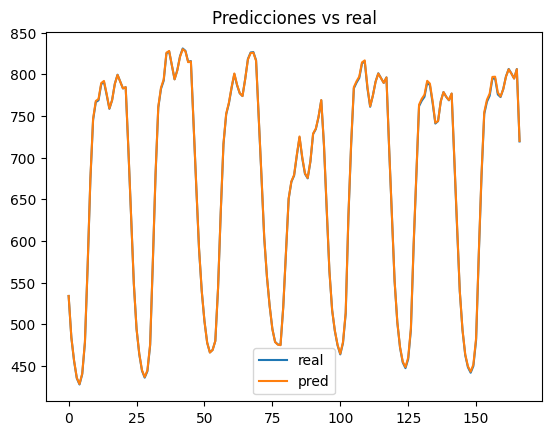

In [19]:
# CREACIÓN DATASETS

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

input_length = 168
output_length = 1

#Seleccionamos 1 semana de validación, 1 semana de test, y el resto para train
ntrain = len(df)-2*24*7-input_length
nval = 24*7

array = df["demanda"].values
shape = array.shape
if len(shape)==1: # Si tenemos sólo una serie (univariado)
    fils, cols = array.shape[0], 1
    array = array.reshape(fils,cols)
else: # Multivariado
    fils, cols = array.shape

for i in range(fils-input_length-output_length):
    if len(x_train) < ntrain:
        x_train.append(array[[i,i+7,i+input_length],0:cols])
        y_train.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    elif len(x_val) < nval:
        x_val.append(array[[i,i+7,i+input_length],0:cols])
        y_val.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    else:
        x_test.append(array[[i,i+7,i+input_length],0:cols])
        y_test.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_train.shape}, y_tr: {y_train.shape}')
print(f'Set de validación - x_vl: {x_val.shape}, y_vl: {y_val.shape}')
print(f'Set de prueba - x_ts: {x_test.shape}, y_ts: {y_test.shape}')

#ESCALADO

NFEATS = x_train.shape[2]
scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

x_train_s = np.zeros(x_train.shape)
x_val_s = np.zeros(x_val.shape)
x_test_s = np.zeros(x_test.shape)
y_train_s = np.zeros(y_train.shape)
y_val_s = np.zeros(y_val.shape)
y_test_s = np.zeros(y_test.shape)

for i in range(NFEATS):
    x_train_s[:,:,i] = scalers[i].fit_transform(x_train[:,:,i])
    x_val_s[:,:,i] = scalers[i].transform(x_val[:,:,i])
    x_test_s[:,:,i] = scalers[i].transform(x_test[:,:,i])
y_train_s[:,:,0] = scalers[-1].fit_transform(y_train[:,:,0])
y_val_s[:,:,0] = scalers[-1].transform(y_val[:,:,0])
y_test_s[:,:,0] = scalers[-1].transform(y_test[:,:,0])

# CREACIÓN RED NEURONAL

def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

INPUT_SHAPE = (x_train_s.shape[1], x_train_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(24, activation='linear'))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))
optimizador = Adam(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)
print(modelo.summary())
historia = modelo.fit(
    x = x_train_s,
    y = y_train_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val_s, y_val_s),
    verbose=2
)

rmse_train = modelo.evaluate(x=x_train_s, y=y_train_s, verbose=0)
rmse_val = modelo.evaluate(x=x_val_s, y=y_val_s, verbose=0)
rmse_test = modelo.evaluate(x=x_test_s, y=y_test_s, verbose=0)

print('Comparación de desempeños:')
print(f'  RMSE train:\t {rmse_train:.3f}')
print(f'  RMSE val:\t {rmse_val:.3f}')
print(f'  RMSE test:\t {rmse_test:.3f}')

y_test_pred = predecir(x_test_s, modelo, scalers[0])
print(root_mean_squared_error(y_test.flatten(), y_test_pred))

plt.figure()
plt.plot(range(len(y_test)), y_test.flatten(), label = "real")
plt.plot(range(len(y_test)), y_test_pred, label = "pred")
plt.legend(loc="best")
plt.title("Predicciones vs real")
plt.show()

### 4.3.2 [Conclusiones del modelo](#0) <a id="4.3.2"></a>

<br>

En este tercer modelo hemos considerado los últimos 168 instantes de tiempo, la capa de neuronas LSTM la hemos cambiado a 168, y hemos añadido complejidad al modelo mediante una capa densa de 24 neuronas. Sabíamos que necesitábamos tener en cuenta más observaciones, pues con únicamente 24 no obteníamos mucha precisión y no solo los primeros retardos regulares y estacionales son importantes en las predicciones; por el otro lado, la complejidad del modelo quizás era escasa, por lo que añadiendo neuronas y una segunda capa hemos logrado predicciones asombrosas que se ajustan casi perfectamente a los datos reales, con un RMSE inferior de alrededor a 1.

## 4.4 [Modelo con Variable Exógena](#0) <a id="4.4"></a>

Utilizando Variable Exógena Temperatura

Una vez tenemos el modelo utilizando únicamente la demanda eléctrica es hora de probar a utilziar la variable exógena, el procedimiento es similar al anterior pero en vez de disponer de una variable en conjunto X, dispondremos de 2: la demanda y la temperatura

In [20]:
input_length = 168
N_UNITS = 168
N_SECOND = 24
EPOCHS = 25
BATCH_SIZE = 1

### 4.4.1 [Definición del modelo](#0) <a id="4.4.1"></a>

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (960, 3, 2), y_tr: (960, 1, 1)
Set de validación - x_vl: (168, 3, 2), y_vl: (168, 1, 1)
Set de prueba - x_ts: (167, 3, 2), y_ts: (167, 1, 1)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 168)               114912    
                                                                 
 dense_4 (Dense)             (None, 24)                4056      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 118993 (464.82 KB)
Trainable params: 118993 (464.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Ep

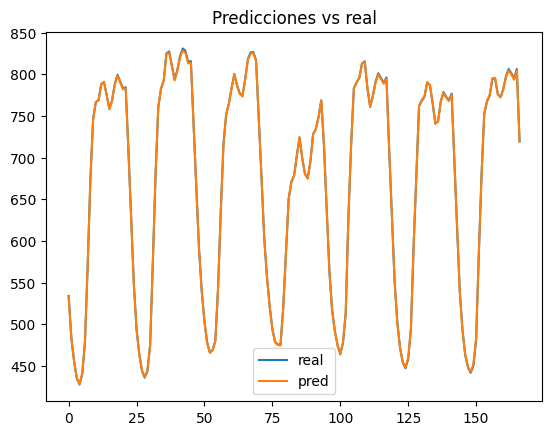

In [21]:
# CREACIÓN DATASETS

x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

input_length = 168
output_length = 1

#Seleccionamos 1 semana de validación, 1 semana de test, y el resto para train
ntrain = len(df)-2*24*7-input_length
nval = 24*7

array = df.values
shape = array.shape
if len(shape)==1: # Si tenemos sólo una serie (univariado)
    fils, cols = array.shape[0], 1
    array = array.reshape(fils,cols)
else: # Multivariado
    fils, cols = array.shape

for i in range(fils-input_length-output_length):
    if len(x_train) < ntrain:
        x_train.append(array[[i,i+7,i+input_length],0:cols])
        y_train.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    elif len(x_val) < nval:
        x_val.append(array[[i,i+7,i+input_length],0:cols])
        y_val.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    else:
        x_test.append(array[[i,i+7,i+input_length],0:cols])
        y_test.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))

x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test = np.array(x_test)
y_test = np.array(y_test)

print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_train.shape}, y_tr: {y_train.shape}')
print(f'Set de validación - x_vl: {x_val.shape}, y_vl: {y_val.shape}')
print(f'Set de prueba - x_ts: {x_test.shape}, y_ts: {y_test.shape}')

#ESCALADO

NFEATS = x_train.shape[2]
scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

x_train_s = np.zeros(x_train.shape)
x_val_s = np.zeros(x_val.shape)
x_test_s = np.zeros(x_test.shape)
y_train_s = np.zeros(y_train.shape)
y_val_s = np.zeros(y_val.shape)
y_test_s = np.zeros(y_test.shape)

for i in range(NFEATS):
    x_train_s[:,:,i] = scalers[i].fit_transform(x_train[:,:,i])
    x_val_s[:,:,i] = scalers[i].transform(x_val[:,:,i])
    x_test_s[:,:,i] = scalers[i].transform(x_test[:,:,i])
y_train_s[:,:,0] = scalers[-1].fit_transform(y_train[:,:,0])
y_val_s[:,:,0] = scalers[-1].transform(y_val[:,:,0])
y_test_s[:,:,0] = scalers[-1].transform(y_test[:,:,0])

# CREACIÓN RED NEURONAL

def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

INPUT_SHAPE = (x_train_s.shape[1], x_train_s.shape[2])

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))
modelo.add(Dense(24, activation='linear'))
modelo.add(Dense(OUTPUT_LENGTH, activation='linear'))
optimizador = Adam(learning_rate=5e-5)
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)
print(modelo.summary())
historia = modelo.fit(
    x = x_train_s,
    y = y_train_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_val_s, y_val_s),
    verbose=2
)

rmse_train = modelo.evaluate(x=x_train_s, y=y_train_s, verbose=0)
rmse_val = modelo.evaluate(x=x_val_s, y=y_val_s, verbose=0)
rmse_test = modelo.evaluate(x=x_test_s, y=y_test_s, verbose=0)

print('Comparación de desempeños:')
print(f'  RMSE train:\t {rmse_train:.3f}')
print(f'  RMSE val:\t {rmse_val:.3f}')
print(f'  RMSE test:\t {rmse_test:.3f}')

y_test_pred = predecir(x_test_s, modelo, scalers[1])
print(root_mean_squared_error(y_test.flatten(), y_test_pred))

plt.figure()
plt.plot(range(len(y_test)), y_test.flatten(), label = "real")
plt.plot(range(len(y_test)), y_test_pred, label = "pred")
plt.legend(loc="best")
plt.title("Predicciones vs real")
plt.show()

### 4.4.2 [Conclusiones del modelo](#0) <a id="4.4.2"></a>

Esta vez añadiendo la variable exógena a los datos, utilizando la misma configuración del modelo 3, las predicciones son incluso mejores, no por mucha diferencia, pero hemos conseguido reducir el RMSE por debajo de 1, por lo que podemos estar satisfechos.

### 5. [Modelo escogido](#0) <a id="5"></a>

Es cierto que los modelos de redes propuestos en R no han sido ajustados con los hiperparámetros óptimos. Esto se debe en parte a la dificultad que supone la falta de desarrollo de las librerías, y al tiempo personal dedicado en estos modelos, pues había más interés en utilizar las redes LSTM que previamente sabemos que son las que mejor funcionan. Quizás mejorando los modelos de redes de R podríamos obtener prediciiones parecidamente buenas. En el caso del modelo ARIMA podría haber sido mejor ajustado, puesto que algunos de los coeficientes de autocorrelación eran significativos, y no debían serlo. Podríamos haber realizado un mejor ajuste para realziar una comparación más realsita con estos modelos LSTM, a pesar de que el modelo ajustado disponía de un RMSE relativamente bajo. La finalidad de nuevo de este modelo era comprender que sucedía en las predicciones y con este conocimiento tratar de ajustar las redes neuronales.

Tomando todas los modelos en consideración, el modelo que utilizaría para las predicciones sería el modelo 4, sabiendo que es la configuración del modelo 3 añadiendo a los datos la variable exógena. Todavía podríamos mejorar el modelo refinando más hiperparámetros, pues tan solo hemos cambiado el número de capas y neuronas, y también el conjunto de datos; pero, hemos logrado predicciones bastante correctas para la tarea que nos habíamos propuesto.